# QC the signals from the ROIs
- I have observed some sessions with weird change in signal
    - Related to false assignment of planes
        - Could be rescued by NOT merging multiple sbx files
- Use F values
    - Remove one frame at each end of each trial (1 at the beginning, 1 at the end)
        - This is because there were many errors with laser off timing
        - JK025-030 has frame_time.pkl
            - Need to make them for 036-052 (230106_build_dataset_organized.ipynb)
    - Average after normalization
    - First, need to make F calculation from suite2p ROIs
        - Not needed at this point, but for the future
        - Right py file for signal extraction (based on 221027_extract_signals_from_masterROI.py)
        - Also refine ROIs based on the suite2p rolling
- Only consider training sessions, not piezo nor sponpt

In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from suite2p.gui import drawroi
from importlib import reload
from tqdm.notebook import tqdm

In [1]:


base_dir = Path(r'E:\TPM\JK\h5')
mice = [25,27,30,36,39,52]
planes = range(1,9)

# Generate tuples of sessions
training_session_tuples = []
for mouse in mice:
    for plane in planes:
        plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
        sessions = [x.name for x in plane_dir.iterdir() if \
                    x.is_dir() and x.name[0].isdigit() and len(x.name)==3]
        # list of (mouse,plane,session) tuples
        for session in sessions:
            training_session_tuples.append((mouse,plane,session))


In [17]:
session_tuple = training_session_tuples[5]
mouse = session_tuple[0]
plane = session_tuple[1]
session = session_tuple[2]
pre_final_roi_fn = base_dir / f'{mouse:03}/plane_{plane}/{session}/plane0/roi/final_roi_results_{mouse:03}_plane_{plane}_{session}_wo_dendrite_filtering.npy'
pre_final_roi = np.load(pre_final_roi_fn, allow_pickle=True).item()
ops_fn = base_dir / f'{mouse:03}/plane_{plane}/{session}/plane0/ops.npy'
ops = np.load(ops_fn, allow_pickle=True).item()

### suite2p parameter explanation
- xoff and yoff are from rigid registration
- xoff1 and yoff1 are from nonrigid registration
- Use xoff and yoff and maxregshiftNR

In [32]:
max_y = np.ceil(max(ops['yoff'].max(), 1)).astype(int)
min_y = np.floor(min(ops['yoff'].min(), 0)).astype(int)
max_x = np.ceil(max(ops['xoff'].max(), 1)).astype(int)
min_x = np.floor(min(ops['xoff'].min(), 0)).astype(int)
maxshiftNR = ops['maxregshiftNR']
range_y = [-min_y + maxshiftNR, -max_y - maxshiftNR]
range_x = [-min_x + maxshiftNR, -max_x - maxshiftNR]


In [49]:
def border_filter_mask(session_tuple, base_dir):
    mouse = session_tuple[0]
    plane = session_tuple[1]
    session = session_tuple[2]
    pre_final_roi_fn = base_dir / f'{mouse:03}/plane_{plane}/{session}/plane0/roi/final_roi_results_{mouse:03}_plane_{plane}_{session}_wo_dendrite_filtering.npy'
    pre_final_roi = np.load(pre_final_roi_fn, allow_pickle=True).item()
    ops_fn = base_dir / f'{mouse:03}/plane_{plane}/{session}/plane0/ops.npy'
    ops = np.load(ops_fn, allow_pickle=True).item()

    range_y, range_x = border_mask(ops)
    
    filter_mask = np.ones((ops['Ly'], ops['Lx']), dtype=bool)
    filter_mask[range_y[0]:range_y[1], range_x[0]:range_x[1]] = False

    final_mask = pre_final_roi['final_mask'].copy()
    num_pre_rois = final_mask.shape[2]
    for ri in range(num_pre_rois):
        if np.any(final_mask[:,:,ri] & filter_mask):
            final_mask[:,:,ri] = False
    
    final_mask, _ = reorder_mask(final_mask)

    return final_mask


def border_mask(ops):
    max_y = np.ceil(max(ops['yoff'].max(), 1)).astype(int)
    min_y = np.floor(min(ops['yoff'].min(), 0)).astype(int)
    max_x = np.ceil(max(ops['xoff'].max(), 1)).astype(int)
    min_x = np.floor(min(ops['xoff'].min(), 0)).astype(int)
    maxshiftNR = ops['maxregshiftNR']
    range_y = [-min_y + maxshiftNR, -max_y - maxshiftNR]
    range_x = [-min_x + maxshiftNR, -max_x - maxshiftNR]
    return range_y, range_x
    

def reorder_mask(mask_3d, startswith=1):
    # Reorder maks ids to be 1 to n
    ids = np.setdiff1d(np.unique(mask_3d), 0)
    new_mask = np.zeros((*mask_3d.shape[:2], len(ids)), dtype=np.uint16)
    for i, id in enumerate(ids):
        y, x = np.where(mask_3d == id)[:2]
        new_mask[y, x, i] = i + startswith
    new_ids = np.setdiff1d(np.unique(new_mask), 0)
    return new_mask, new_ids    

## ops file error
- from 231015_roi_merge_qc.ipynb

In [51]:
roi_collection_error_fn = base_dir / 'roi_collection_error.npy'
roi_collection_error = np.load(roi_collection_error_fn, allow_pickle=True)
roi_collection_error

array([['27', '3', '006'],
       ['27', '3', '007'],
       ['27', '3', '015'],
       ['27', '3', '017'],
       ['27', '3', '023'],
       ['27', '3', '024'],
       ['27', '3', '025'],
       ['27', '3', '5555_001'],
       ['27', '3', '5555_002'],
       ['27', '3', '5555_003'],
       ['27', '3', '5555_013'],
       ['27', '3', '5555_104'],
       ['27', '3', '9999_1'],
       ['27', '3', '9999_2'],
       ['27', '4', '001'],
       ['27', '4', '003'],
       ['27', '4', '004'],
       ['27', '4', '006'],
       ['27', '4', '007'],
       ['27', '4', '015'],
       ['27', '4', '023'],
       ['27', '4', '5555_002'],
       ['27', '4', '5555_003'],
       ['27', '4', '5555_012'],
       ['27', '4', '5555_013'],
       ['27', '4', '5555_104'],
       ['27', '4', '9999_1'],
       ['27', '5', '001'],
       ['27', '5', '002'],
       ['27', '5', '003'],
       ['27', '5', '004'],
       ['27', '5', '005'],
       ['27', '5', '006'],
       ['27', '5', '007'],
       ['27', '5', '008

In [59]:
session_tuple = roi_collection_error[0]
mouse = int(session_tuple[0])
plane = int(session_tuple[1])
session = session_tuple[2]

# check HDD
base_dir = Path('F:\\') if int(mouse) < 31 else Path('D:\\')
session_dir = base_dir / f'{mouse:03}/plane_{plane}/{session}/plane0'
ops_fn = session_dir / 'ops.npy'
ops = np.load(ops_fn, allow_pickle=True).item()

In [61]:
base_ops_fn = Path(r'E:\TPM\JK\h5') / f'{mouse:03}/plane_{plane}/{session}/plane0/ops.npy'
base_ops = np.load(base_ops_fn, allow_pickle=True).item()

In [62]:
for session_tuple in roi_collection_error:
    mouse = int(session_tuple[0])
    plane = int(session_tuple[1])
    session = session_tuple[2]
    base_ops_fn = Path(r'E:\TPM\JK\h5') / f'{mouse:03}/plane_{plane}/{session}/plane0/ops.npy'
    base_ops = np.load(base_ops_fn, allow_pickle=True).item()

In [63]:
len(roi_collection_error)

40

# Save bordering ROIs filtered
- in a separate file
- Also create ROI maps

In [3]:
from scripts import roi_remove_border as rrb

In [11]:
session_tuple = training_session_tuples[0]
mouse = session_tuple[0]
plane = session_tuple[1]
session = session_tuple[2]
pre_final_roi_fn = base_dir / f'{mouse:03}/plane_{plane}/{session}/plane0/roi/final_roi_results_{mouse:03}_plane_{plane}_{session}_wo_dendrite_filtering.npy'
pre_final_roi = np.load(pre_final_roi_fn, allow_pickle=True).item()
ops_fn = base_dir / f'{mouse:03}/plane_{plane}/{session}/plane0/ops.npy'
ops = np.load(ops_fn, allow_pickle=True).item()

range_y, range_x = rrb.border_mask(ops)

filter_mask = np.ones((ops['Ly'], ops['Lx']), dtype=bool)
filter_mask[range_y[0]:range_y[1], range_x[0]:range_x[1]] = False


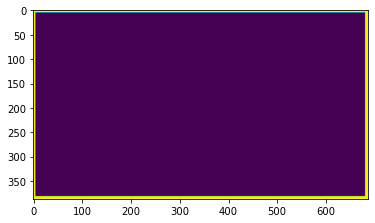

In [12]:
plt.imshow(filter_mask)

In [17]:
final_mask = pre_final_roi['final_mask'].copy()
num_pre_rois = final_mask.shape[2]
for ri in range(num_pre_rois):
    if np.any(final_mask[:,:,ri] * filter_mask):
        final_mask[:,:,ri] = False
        print(ri)

0
14
50
63
68
70
91
106
152
155


C:\Users\shires\AppData\Local\Temp/ipykernel_7568/2557534636.py:5: UserWarning: No contour levels were found within the data range.
  ax.contour(final_mask[:,:,i], colors='r', linewidths=0.5)


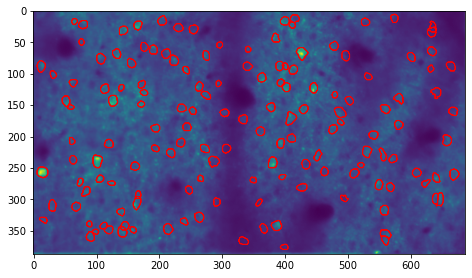

In [18]:
mean_img = ops['meanImg']
fig, ax = plt.subplots(figsize=(mean_img.shape[0]*0.02, mean_img.shape[1]*0.02))
ax.imshow(mean_img)
for i in range(final_mask.shape[-1]):
    ax.contour(final_mask[:,:,i], colors='r', linewidths=0.5)


In [19]:
from importlib import reload
reload(rrb)
final_mask = rrb.border_filter_mask(session_tuple, base_dir)

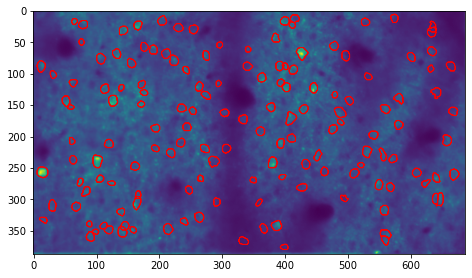

In [20]:
ops_fn = base_dir / f'{mouse:03}/plane_{plane}/{session}/plane0/ops.npy'
ops = np.load(ops_fn, allow_pickle=True).item()
mean_img = ops['meanImg']
fig, ax = plt.subplots(figsize=(mean_img.shape[0]*0.02, mean_img.shape[1]*0.02))
ax.imshow(mean_img)
for i in range(final_mask.shape[-1]):
    ax.contour(final_mask[:,:,i], colors='r', linewidths=0.5)


# Get signal from the ROIs
- Only the zdrift matched training sessions
- following 221027_extract_signals_from_masterROI.py

In [21]:
base_dir = Path(r'E:\TPM\JK\h5')
mice = [25,27,30,36,39,52]
planes = range(1,9)

matched_session_tuples = []
for mouse in mice:
    for plane in planes:
        plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
        sessions = [x.name for x in plane_dir.iterdir() if \
                    x.is_dir() and x.name[0].isdigit() and len(x.name)==3]
        # list of (mouse,plane,session) tuples
        for session in sessions:
            matched_session_tuples.append((mouse,plane,session))

[25, 27, 30, 36, 39, 52]

In [45]:
matched_session_tuples = []
error_planes = []
for mouse in mice:
    for plane in planes:
        plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
        reg_fn = plane_dir / f'JK{mouse:03}_plane{plane}_session_to_session_registration.npy'
        try:
            reg_result = np.load(reg_fn, allow_pickle=True).item()
            matched_session_nums = [sn for sn in reg_result['selected_session_num'] if sn < 100]
            for sn in matched_session_nums:
                matched_session_tuples.append((mouse,plane,f'{sn:03}'))
        except:
            error_planes.append((mouse, plane))


In [46]:
error_planes

[]

In [75]:
session_tuple = matched_session_tuples[0]
mouse = session_tuple[0]
plane = session_tuple[1]
session = session_tuple[2]
final_mask_fn = base_dir / f'{mouse:03}/plane_{plane}/{session}/plane0/roi/final_mask.npy'
final_mask = np.load(final_mask_fn)
ops_fn = base_dir / f'{mouse:03}/plane_{plane}/{session}/plane0/ops.npy'
ops = np.load(ops_fn, allow_pickle=True).item()
ops['reg_file'] = base_dir / f'{mouse:03}/plane_{plane}/{session}/plane0/data.bin'

In [84]:
from suite2p.gui import drawroi
reload(drawroi)

numROI = final_mask.shape[2]
statBlank = []
stat0 = []
for ci in range(numROI):
    roi_mask = final_mask[:,:,ci]
    (ypix, xpix) = np.unravel_index(np.where(roi_mask.flatten())[0], roi_mask.shape)
    lam = np.ones(ypix.shape)/len(ypix)
    med = (np.median(ypix), np.median(xpix))
    stat0.append({'ypix': ypix, 'xpix': xpix, 'lam': lam, 'npix': ypix.size, 'med': med})
F, Fneu, _, _, spks, ops, stat = drawroi.masks_and_traces(ops, stat0, statBlank)
iscell = np.ones((numROI,2), 'uint8')

Masks made in 1.75 sec.
Extracted fluorescence from 146 ROIs in 5006 frames, 9.77 sec.


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [89]:
frame_time_fn = base_dir / f'{mouse:03}/plane_{plane}/{mouse:03}_{session}_plane_{plane}_frame_time.pkl'
frame_time = pd.read_pickle(frame_time_fn)

In [113]:
reduced_frame_time = frame_time.groupby('trialNum').apply(lambda x: x.iloc[1:-1]).reset_index(drop=True)
reduced_frame_indice = reduced_frame_time.frame_index.values.astype(int)
F_reduced = F[:,reduced_frame_indice]
Fneu_reduced = Fneu[:,reduced_frame_indice]
spks_reduced = spks[:,reduced_frame_indice]


In [115]:
roi_dir = base_dir / f'{mouse:03}/plane_{plane}/{session}/plane0/roi'
F_fn = roi_dir / 'F_reduced.npy'
Fneu_fn = roi_dir / 'Fneu_reduced.npy'
spks_fn = roi_dir / 'spks_reduced.npy'
reduced_frame_time_fn = roi_dir / 'reduced_frame_time.pkl'
ops_fn = roi_dir / 'ops.npy'
stat_fn = roi_dir / 'stat.npy'
iscell_fn = roi_dir / 'iscell.npy'
np.save(F_fn, F_reduced)
np.save(Fneu_fn, Fneu_reduced)
np.save(spks_fn, spks_reduced)
reduced_frame_time.to_pickle(reduced_frame_time_fn)
np.save(ops_fn, ops)
np.save(stat_fn, stat)
np.save(iscell_fn, iscell)


In [10]:
def save_signal(mouse, plane, session, base_dir):
    
    plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
    session_dir = plane_dir / f'{session}/plane0'
    roi_dir = session_dir / 'roi'
    final_mask_fn = roi_dir / 'final_mask.npy'
    final_mask = np.load(final_mask_fn)
    ops_fn = session_dir / 'ops.npy'
    ops = np.load(ops_fn, allow_pickle=True).item()
    ops['reg_file'] = session_dir / 'data.bin'

    # Get signals from the mask
    numROI = final_mask.shape[2]
    statBlank = []
    stat0 = []
    for ci in range(numROI):
        roi_mask = final_mask[:,:,ci]
        (ypix, xpix) = np.unravel_index(np.where(roi_mask.flatten())[0], roi_mask.shape)
        lam = np.ones(ypix.shape)/len(ypix)
        med = (np.median(ypix), np.median(xpix))
        stat0.append({'ypix': ypix, 'xpix': xpix, 'lam': lam, 'npix': ypix.size, 'med': med})
    F, Fneu, _, _, spks, ops, stat = drawroi.masks_and_traces(ops, stat0, statBlank)
    iscell = np.ones((numROI,2), 'uint8')

    # Get frame time to remove first and last frame of each trial
    # to remove negative ticks from laser blocking
    frame_time_fn = plane_dir / f'{mouse:03}_{session}_plane_{plane}_frame_time.pkl'
    frame_time = pd.read_pickle(frame_time_fn)
    reduced_frame_time = frame_time.groupby('trialNum').apply(lambda x: x.iloc[1:-1]).reset_index(drop=True)
    reduced_frame_indice = reduced_frame_time.frame_index.values.astype(int)

    F_reduced = F[:,reduced_frame_indice]
    Fneu_reduced = Fneu[:,reduced_frame_indice]
    spks_reduced = spks[:,reduced_frame_indice]

    # Save the results
    F_fn = roi_dir / 'F_reduced.npy'
    Fneu_fn = roi_dir / 'Fneu_reduced.npy'
    spks_fn = roi_dir / 'spks_reduced.npy'
    reduced_frame_time_fn = roi_dir / 'reduced_frame_time.pkl'
    ops_fn = roi_dir / 'ops.npy'
    stat_fn = roi_dir / 'stat.npy'
    iscell_fn = roi_dir / 'iscell.npy'
    np.save(F_fn, F_reduced)
    np.save(Fneu_fn, Fneu_reduced)
    np.save(spks_fn, spks_reduced)
    reduced_frame_time.to_pickle(reduced_frame_time_fn)
    np.save(ops_fn, ops)
    np.save(stat_fn, stat)
    np.save(iscell_fn, iscell)

## Check if all the sessions have frame_time.pkl
- if not, make them first

In [118]:
no_frame_time_pkls = []
for session_tuple in tqdm(matched_session_tuples):
    mouse = session_tuple[0]
    plane = session_tuple[1]
    session = session_tuple[2]
    frame_time_fn = base_dir / f'{mouse:03}/plane_{plane}/{mouse:03}_{session}_plane_{plane}_frame_time.pkl'
    if not frame_time_fn.exists():
        no_frame_time_pkls.append(session_tuple)

  0%|          | 0/916 [00:00<?, ?it/s]

#no_frame_time_pkls
### 036,039,052 don't have them
- Run in 221024_build_dataset.ipynb
    - A problem with # of frames (36 S010 lower volume)
        - May need to rebuild .trials file - check in detail

In [ ]:
# Run for the first 3 mice first (cause it takes quite long)
# Took 107 min till JK027, plane 4
# 115 min after that
run_session_tuples = []
for mouse in mice[3:]:
    for plane in planes:
        plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
        reg_fn = plane_dir / f'JK{mouse:03}_plane{plane}_session_to_session_registration.npy'
        reg_result = np.load(reg_fn, allow_pickle=True).item()
        matched_session_nums = [sn for sn in reg_result['selected_session_num'] if sn < 100]
        for sn in matched_session_nums:
            run_session_tuples.append((mouse,plane,f'{sn:03}'))

for session_tuple in tqdm(run_session_tuples):
    mouse = session_tuple[0]
    plane = session_tuple[1]
    session = session_tuple[2]
    roi_dir = base_dir / f'{mouse:03}/plane_{plane}/{session}/plane0/roi'
    iscell_fn = roi_dir / 'iscell.npy'
    if (roi_dir / iscell_fn).exists():
        continue
    else:
        print(f'Processing {mouse:03} plane {plane} session {session}')
        try:
            save_signal(mouse, plane, session, base_dir)
        except:
            print(f'Error in {mouse:03} plane {plane} session {session}')
            continue

# Rerun JK027 from HDD
- Weird signal issue, it might be due to data compromised from RAID problem before

In [ ]:
# Run for the first 3 mice first (cause it takes quite long)
# Took 107 min till JK027, plane 4
# 115 min after that
run_session_tuples = []
mouse = 27
temp_basedir = Path(r'F:')
for plane in planes:
    plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
    reg_fn = plane_dir / f'JK{mouse:03}_plane{plane}_session_to_session_registration.npy'
    reg_result = np.load(reg_fn, allow_pickle=True).item()
    matched_session_nums = [sn for sn in reg_result['selected_session_num'] if sn < 100]
    for sn in matched_session_nums:
        run_session_tuples.append((mouse,plane,f'{sn:03}'))

for session_tuple in tqdm(run_session_tuples):
    mouse = session_tuple[0]
    plane = session_tuple[1]
    session = session_tuple[2]
    roi_dir = base_dir / f'{mouse:03}/plane_{plane}/{session}/plane0/roi'
    iscell_fn = roi_dir / 'iscell.npy'
    # if (roi_dir / iscell_fn).exists():
    #     continue
    # else:
    print(f'Processing {mouse:03} plane {plane} session {session}')
    try:
        save_signal(mouse, plane, session, temp_basedir)
    except:
        print(f'Error in {mouse:03} plane {plane} session {session}')
        continue

### JK027 session 004 has a problem
- in data.bin
- see if h5 file is fine.
    - if so, re-run this h5 file up to registration, check if the mean image is the same as before, and if so, swap this data.bin file
    

In [122]:
mouse, plane, session

(27, 5, '001')

In [131]:
# # test reading frame_time.pkl
# from tqdm.notebook import tqdm
# frame_time_error_session_tuples = []
# for session_tuple in tqdm(matched_session_tuples):
#     mouse = session_tuple[0]
#     plane = session_tuple[1]
#     session = session_tuple[2]
#     frame_time_fn = base_dir / f'{mouse:03}/plane_{plane}/{mouse:03}_{session}_plane_{plane}_frame_time.pkl'
#     try:
#         frame_time = pd.read_pickle(frame_time_fn)
#     except:
#         frame_time_error_session_tuples.append(session_tuple)

  0%|          | 0/916 [00:00<?, ?it/s]

### From time to time, exact same file works from HDD but not from RAID.
- Always first check if all relevant pkl and npy files work 

In [129]:
mouse = 27
hdd_dir = Path('F:\\') if int(mouse) < 31 else Path('D:\\')
plane = 5

plane_dir = hdd_dir / f'{mouse:03}/plane_{plane}'
frame_time_fn_list = [x for x in plane_dir.iterdir() if '_frame_time.pkl' in x.name]
for fn in frame_time_fn_list:
    try:
        frame_time = pd.read_pickle(fn)
    except:
        print(f'Error in {fn}')


# Generate figures of mean fluoresscence signal
- Not DFF, just F, to check faulty frame assignment

In [182]:
run_session_tuples = []

temp_basedir = Path(r'F:')
# for mouse in mice:
for mouse in [27]:
    for plane_top in [1,5]:
        plane_dir = base_dir / f'{mouse:03}/plane_{plane_top}'
        reg_fn = plane_dir / f'JK{mouse:03}_plane{plane_top}_session_to_session_registration.npy'
        reg_result = np.load(reg_fn, allow_pickle=True).item()
        matched_session_nums = [sn for sn in reg_result['selected_session_num'] if sn < 100]
        for sn in matched_session_nums:
            run_session_tuples.append((mouse,plane_top,f'{sn:03}'))

for session_tuple in tqdm(run_session_tuples):
    mouse = session_tuple[0]
    plane_top = session_tuple[1]
    session = session_tuple[2]

    fig, ax = plt.subplots(figsize=(15,5))
    for plane in range(plane_top, plane_top + 4):
        # roi_dir = base_dir / f'{mouse:03}/plane_{plane}/{session}/plane0/roi'
        roi_dir = temp_basedir / f'{mouse:03}/plane_{plane}/{session}/plane0/roi'
        F_fn = roi_dir / 'F_reduced.npy'

        if not F_fn.exists():
            print(f'{mouse:03} plane {plane} session {session} does not exist')
        else:
            F = np.load(F_fn)
            F_mean = F.mean(axis=0)

            ax.plot(F_mean, label=f'plane {plane}')    
    ax.legend()
    ax.set_title(f'{mouse:03} {session} F_mean')
    fig.savefig(base_dir / f'{mouse:03}' / f'{session}_F_mean_top{plane_top}.png')
    plt.close(fig)


  0%|          | 0/25 [00:00<?, ?it/s]

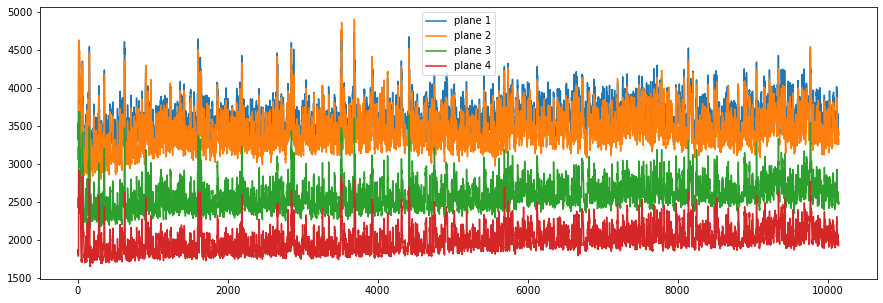

In [145]:
mouse = 36
session_num = 1
plane_top = 1

fig, ax = plt.subplots(figsize=(15,5))
for plane in range(plane_top, plane_top + 4):
    roi_dir = base_dir / f'{mouse:03}/plane_{plane}/{session_num:03d}/plane0/roi'
    F_fn = roi_dir / 'F_reduced.npy'

    F = np.load(F_fn)
    F_mean = F.mean(axis=0)
    ax.plot(F_mean, label=f'plane {plane}')

    Fneu_fn = roi_dir / 'Fneu_reduced.npy'
    Fneu = np.load(Fneu_fn)

ax.legend()

# Look at the individual cases where the signals look suspicious

In [149]:
from suite2p.io.binary import BinaryFile
import napari

In [187]:
mouse = 27
session = 4
plane = 4

# trials_fn = base_dir / f'{mouse:03}' / f'{mouse:03}_{session:03}_000.trials'

plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
databin_fn = plane_dir / f'{session:03d}' / 'plane0' / 'data.bin'
ops = np.load(plane_dir / f'{session:03d}' / 'plane0' / 'ops.npy', allow_pickle=True).item()
Ly = ops['Ly']
Lx = ops['Lx']



In [191]:
observe_frames = [0, 5000]
average_dur = 50
frame_segments = np.arange(observe_frames[0], observe_frames[1] + average_dur, average_dur)

segment_fov = []
for segment in frame_segments:
    frame_segment = np.arange(segment, segment + average_dur)
    with BinaryFile(Ly=Ly, Lx=Lx, read_filename=databin_fn) as bin_file:
        frames = bin_file.ix(indices=frame_segment)
        mean_img = frames.mean(axis=0)
        segment_fov.append(mean_img)

segment_fov = np.stack(segment_fov)

viewer = napari.Viewer()
viewer.add_image(segment_fov, name='segment_fov')
viewer.add_image(ops['meanImg'], name='meanImg')


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


<Image layer 'meanImg' at 0x202b457ffa0>

In [194]:
import h5py
h5fn = Path(r'F:\027\plane_4') / '027_004_000_plane_4.h5'
segment_fov_h5 = []
with h5py.File(h5fn, 'r') as h:
    for segment in frame_segments:
        frame_segment = np.arange(segment, segment + average_dur)
        frames = h['data'][frame_segment]
        mean_img = frames.mean(axis=0)
        segment_fov_h5.append(mean_img)

segment_fov_h5 = np.stack(segment_fov_h5)

viewer = napari.Viewer()
viewer.add_image(segment_fov_h5, name='segment_fov')
viewer.add_image(ops['meanImg'], name='meanImg')

c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


<Image layer 'meanImg' at 0x202b84bf520>

### re-process JK027 from HDD h5 files
- Check if the ops['meanImg'] is the same (or registration results)
- They're different - just run ROI detection again (and session-to-session registrations as well)

In [202]:
mouse = 27
session=4
plane = 2
new_ops_fn = Path(r'F:\027') / f'plane_{plane}\{session:03}\plane0' / 'ops.npy'
new_ops = np.load(new_ops_fn, allow_pickle=True).item()
old_ops_fn = Path(r'F:\027') / f'plane_{plane}\{session:03}\plane0\prev_suite2p_run' / 'ops.npy'
old_ops = np.load(old_ops_fn, allow_pickle=True).item()


In [203]:
new_meanimg = new_ops['meanImg']
old_meanimg = old_ops['meanImg']
(new_meanimg - old_meanimg).any()

True

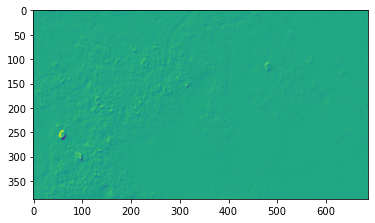

In [204]:
fig, ax = plt.subplots()
ax.imshow(new_meanimg - old_meanimg)

In [205]:
viewer = napari.Viewer()
viewer.add_image(old_meanimg, name='old meanImg')
viewer.add_image(new_meanimg, name='new meanImg')

c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


<Image layer 'new meanImg' at 0x20222ba2100>

## Reprocess for JK027 S004 done,
- Using single_session_suite2p.py, 230910_roi_collation_parallel.py
- Slight change in the registration - so need to change all the files to the new processed files.
    - Old ones moved to 'prev_suite2p_run' folder
- All JK027 'roi' folder files are changed - why??
## But they don't have 'max_proj' in the option.
- When running 230910_cp_masks_parallel.py
- It was because I ran through registration only.
    - max_proj is created at the detection part.
- Add max_proj manually.
## Add them and process further
- Using add_max_proj.ipynb
- The function is added to single_session_suite2p.py
## Next step:
1. Create ..._cp_masks.npy
    - Using 230910_cp_masks_parallel.py
2. ROI collation
    - Using 230910_roi_collation_parallel.py
3. Remove ROIs from the border
    - scripts.roi_remove_border > border_filter_mask
    - This creates the final_mask.npy

In [8]:
from scripts import roi_remove_border as rrb
base_dir_temp = Path('F:')
mouse = 27
session = '004'
for plane in range(1,9):
    session_tuple = (mouse, plane, session)
    final_mask = rrb.border_filter_mask(session_tuple, base_dir_temp)
    final_mask_fn = base_dir_temp / f'{mouse:03}/plane_{plane}/{session}/plane0/roi/final_mask.npy'
    np.save(final_mask_fn, final_mask)

In [11]:
base_dir_temp = Path('F:')
mouse = 27
session = '004'
for plane in range(1,9):
    save_signal(mouse, plane, session, base_dir_temp)

Masks made in 1.84 sec.


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numba\core\ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'cell_ipix' of function 'matmul_traces'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\..\..\..\Anaconda3\envs\suite2p\lib\site-packages\suite2p\extraction\extract.py", line 105:
@njit(parallel=True)
def matmul_traces(Fi, data, cell_ipix, cell_lam):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numba\core\ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'cell_lam' of function 'matmul_traces'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference

Extracted fluorescence from 133 ROIs in 12320 frames, 27.80 sec.


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Masks made in 2.09 sec.
Extracted fluorescence from 155 ROIs in 12320 frames, 20.28 sec.


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Masks made in 1.88 sec.
Extracted fluorescence from 145 ROIs in 12320 frames, 19.76 sec.


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Masks made in 1.90 sec.
Extracted fluorescence from 168 ROIs in 12320 frames, 19.92 sec.


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Masks made in 2.10 sec.
Extracted fluorescence from 177 ROIs in 11347 frames, 18.66 sec.


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Masks made in 1.72 sec.
Extracted fluorescence from 149 ROIs in 11347 frames, 17.76 sec.


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Masks made in 1.64 sec.
Extracted fluorescence from 118 ROIs in 11347 frames, 18.02 sec.


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Masks made in 2.17 sec.
Extracted fluorescence from 161 ROIs in 11347 frames, 18.46 sec.


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


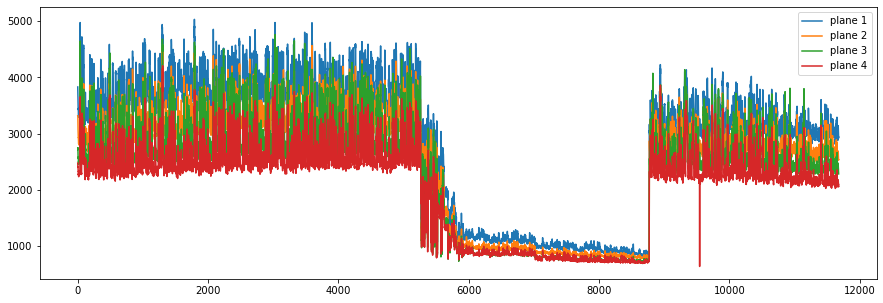

In [12]:
# check the result of JK027 S004
base_dir_temp = Path('F:')
mouse = 27
session_num = 4
plane_top = 1

fig, ax = plt.subplots(figsize=(15,5))
for plane in range(plane_top, plane_top + 4):
    roi_dir = base_dir_temp / f'{mouse:03}/plane_{plane}/{session_num:03d}/plane0/roi'
    F_fn = roi_dir / 'F_reduced.npy'

    F = np.load(F_fn)
    F_mean = F.mean(axis=0)
    ax.plot(F_mean, label=f'plane {plane}')

    Fneu_fn = roi_dir / 'Fneu_reduced.npy'
    Fneu = np.load(Fneu_fn)

ax.legend()

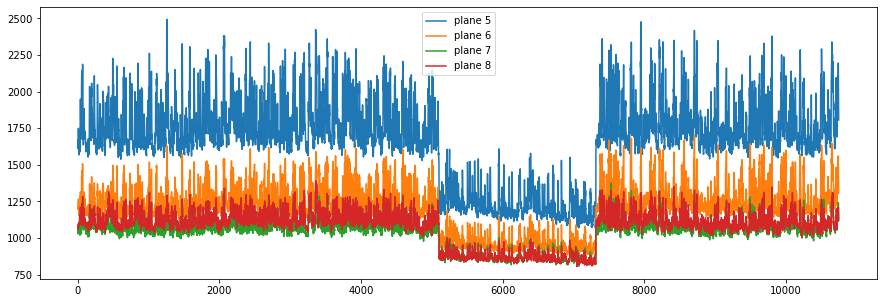

In [13]:
# check the result of JK027 S004
base_dir_temp = Path('F:')
mouse = 27
session_num = 4
plane_top = 5

fig, ax = plt.subplots(figsize=(15,5))
for plane in range(plane_top, plane_top + 4):
    roi_dir = base_dir_temp / f'{mouse:03}/plane_{plane}/{session_num:03d}/plane0/roi'
    F_fn = roi_dir / 'F_reduced.npy'

    F = np.load(F_fn)
    F_mean = F.mean(axis=0)
    ax.plot(F_mean, label=f'plane {plane}')

    Fneu_fn = roi_dir / 'Fneu_reduced.npy'
    Fneu = np.load(Fneu_fn)

ax.legend()

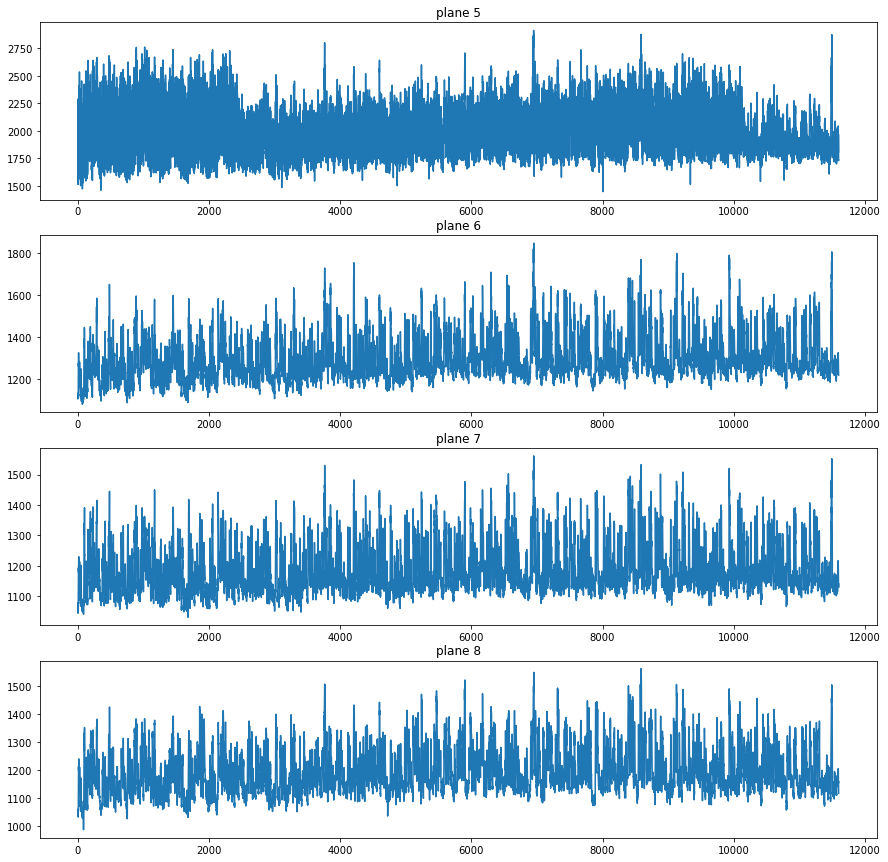

In [177]:
mouse = 27
session_num = 1
plane_top = 5

fig, ax = plt.subplots(4,1,figsize=(15,15))
for pi, plane in enumerate(range(plane_top, plane_top + 4)):
    roi_dir = base_dir / f'{mouse:03}/plane_{plane}/{session_num:03d}/plane0/roi'
    F_fn = roi_dir / 'F_reduced.npy'

    F = np.load(F_fn)
    F_mean = F.mean(axis=0)
    ax[pi].plot(F_mean, label=f'plane {plane}')

    ax[pi].set_title(f'plane {plane}')

In [139]:
F.mean(axis=0).shape

(7676,)